# The original dataset should be sized and normalised as well and save to merged folder

In [4]:
from torchvision.utils import save_image
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
torch.manual_seed(42)

original_folder = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\6_Dataset\_Data for model\2_selected for ML"
transformed_folder = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\6_Dataset\_Data for model\2.1_original_normalised"


my_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        
        transforms.Resize((224, 224)),  # Resizes
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] #https://pytorch.org/vision/stable/models.html
        ),
    ]
)

for _, filename in enumerate([f for f in os.listdir(original_folder) if not f.startswith('.')]):
    img = Image.open(original_folder+"/"+filename)
    img = my_transforms(img)
    save_image(img, transformed_folder + "/" + filename)

# Transfer learning

In [1]:
# https://www.youtube.com/watch?v=qaDe0qQZ5AQ
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt
torch.manual_seed(42)#You can use torch.manual_seed function to seed the script globally
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from skimage import io
import os
from torch.utils.data import Dataset

In [2]:
'''Hyperparameters'''
num_classes = 3
learning_rate = 1e-4
batch_size = 100
num_epochs = 200
test_size = 0.25

# two writers for different colour
# 如果重新写入数据的话，就要关闭tensorboard然后重新运行下列writter代码
writer = SummaryWriter('runs/resnet_noAug_layer4&fc')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# real data path
path_merged = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\6_Dataset\_Data for model\2.1_original_normalised"
# # less image for quick train test
# path_merged = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\4_smallDataset'

In [3]:

# Designed for equal portion split  
class WallDefects(Dataset): #inherit from Dataset
    def __init__(self, root_dir, data, label, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index])
        image = io.imread(img_path)
        y_label = torch.tensor(self.label[index])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    
    
# or you want equal portion for each classes
# using tensorflow train_test_split, stratify=y for equal portion split based on label
# https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/5
X = np.array([f for f in os.listdir(path_merged) if not f.startswith('.')])
y = np.array([filename[0] for filename in X]).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)

train_set = WallDefects(path_merged, data=X_train, label=y_train, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = WallDefects(path_merged, data=X_test, label=y_test,transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [4]:
len(X),len(X_train),len(X_test)

(4612, 3459, 1153)

target label: 1


(<matplotlib.image.AxesImage at 0x21f6f4a6220>, None)

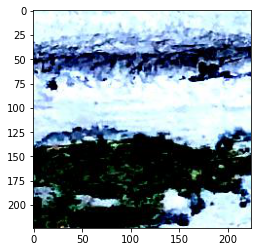

In [5]:
# 0_non: 2000
# 1_bigrowth:657 * 3 = 1971
# 2_crack: 1955
# total images = 2000+1971+1955=5926

def showImage(index, dataset):
    return plt.imshow(dataset[index][0].permute(1, 2, 0)),print(f'target label: {dataset[index][1]}')
showImage(-1, train_set) 

In [6]:

'''Load pretrained model'''
# Load pretrain model 
model = torchvision.models.resnet50(pretrained=True)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in model.parameters():
    param.requires_grad = False

# set last layer trainable for to evalate the localisation capability since fc does not do localisation
# you could also be more specific, like layer4[0], here we train the entire layer4
for param in model.layer4.parameters():
    param.requires_grad = True

'''Modify the fully connected layer of the model'''
# modify the last fully connected layer to simple layer, because we wanna train lasy conv layer 
# which should be trained to do classificaiton and localisation both well
model.fc = nn.Sequential(
    nn.Linear(2048, num_classes)
)


# # how about freeze the fc as well, try if layer4 can do better localsation, since all classificaiton and
# # localisation work is done by layer 4
# for param in model.fc.parameters():
#     param.requires_grad = False



model.to(device)
print(model)


# complicate fc in the first experiment
# model.fc = nn.Sequential(
#     nn.Linear(2048, 1000), nn.ReLU(), 
#     nn.Linear(1000, 500), nn.ReLU(), 
#     nn.Linear(500, 200), nn.ReLU(), 
#     nn.Linear(200, num_classes)
# )

C:\Users\SmartLab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\SmartLab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# check which layer requires grad
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        
        
# how about fixing FC layers? 
# so all the learning happens in the last convlayer, is it even better for localisation?

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.0.weight
fc.0.bias


In [8]:
'''Training and check the cost'''
# difference btw ce and bce, here we use ce as later data size all based on it
# https://discuss.pytorch.org/t/can-i-use-cross-entropy-loss-as-a-binary-loss/39314/2
# Loss
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() #binary cross entrpy


# pytorch optimizer explicitly accepts parameter that requires grad
# We haven’t done yet as even the required grad is set to False, we still can update the weights
# So we should filter the parameters to only those requires_grad ones by using this code
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)



lowest_loss = 9999
# Train Network
for epoch in range(num_epochs):
    
    '''training loss and accuracy cals'''
    losses = []
    num_correct = 0
    num_samples = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.type(torch.LongTensor)
        targets = targets.to(device=device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        # for accuracy cals
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)


    # tensorboard
    # 因为存储的文件有很多不规则名字（例如_）所以直接用 tensorboard --logdir=runs 是找不到的，所以
    # 需要用他之前规则的路径，然后tensorboard会在这个大路径里面搜寻文件，例如下面这个就是规则大路径
    # runs文件和这个python文件在一起，但是不能用这个路径因为有不规则符号
    # terminal: tensorboard --logdir /Users/t.wang/Desktop/NUS/References
    writer.add_scalar("Loss/ ->Train", sum(losses)/len(losses), epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {sum(losses)/len(losses):.5f} -> Training cost")
    
    # tensorboard
    # terminal: tensorboard --logdir=runs
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Training", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Training accuracy"
    )
    
    
    
    '''test loss and accuracy cals'''
    model.eval() #no model tuning, just for test checking
    losses = []
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device=device)
            # forward
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss)
            # for accuracy cals
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    # Loss
    current_loss = sum(losses)/len(losses)
    writer.add_scalar("Loss/ ->Test", current_loss, epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {current_loss:.5f} -> Testing cost") 
    
    # Accuracy
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Testing", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Testing accuracy"
    )

    
    # store the best model in terms of the loss
    if current_loss < lowest_loss:
        num = epoch+1
        best_model = model
        lowest_loss = current_loss
        highest_acc = accuracy
    print(f'the current best model is from epoch {num}')  
    print("==============================================================================")
    # Call flush() method to make sure that all pending events have been written to disk.  
    writer.flush()
    model.train() # back to model tuning again
    
    
# save the best model
print(f'saving the best model at {num}th epoch...')
torch.save(best_model.state_dict(), f'{num}th epoch_resnet_noAug_layer4&fc_Testingloss={lowest_loss:.5f} and acc={highest_acc}%.pth')        
print('Job Done!!!!!')

# 大概5h算10epoch，半小时1个epoch

Epoch 1 / 200 is 1.02299 -> Training cost
Got 1599 correct / 3459 in total with accuracy 46.23% -> Training accuracy
Epoch 1 / 200 is 0.93003 -> Testing cost
Got 670 correct / 1153 in total with accuracy 58.11% -> Testing accuracy
the current best model is from epoch 1
Epoch 2 / 200 is 0.86316 -> Training cost
Got 2337 correct / 3459 in total with accuracy 67.56% -> Training accuracy
Epoch 2 / 200 is 0.79893 -> Testing cost
Got 839 correct / 1153 in total with accuracy 72.77% -> Testing accuracy
the current best model is from epoch 2
Epoch 3 / 200 is 0.75088 -> Training cost
Got 2587 correct / 3459 in total with accuracy 74.79% -> Training accuracy
Epoch 3 / 200 is 0.70117 -> Testing cost
Got 896 correct / 1153 in total with accuracy 77.71% -> Testing accuracy
the current best model is from epoch 3
Epoch 4 / 200 is 0.66492 -> Training cost
Got 2783 correct / 3459 in total with accuracy 80.46% -> Training accuracy
Epoch 4 / 200 is 0.62101 -> Testing cost
Got 934 correct / 1153 in total 

Epoch 24 / 200 is 0.25690 -> Testing cost
Got 1052 correct / 1153 in total with accuracy 91.24% -> Testing accuracy
the current best model is from epoch 24
Epoch 25 / 200 is 0.22545 -> Training cost
Got 3199 correct / 3459 in total with accuracy 92.48% -> Training accuracy
Epoch 25 / 200 is 0.25485 -> Testing cost
Got 1056 correct / 1153 in total with accuracy 91.59% -> Testing accuracy
the current best model is from epoch 25
Epoch 26 / 200 is 0.21708 -> Training cost
Got 3214 correct / 3459 in total with accuracy 92.92% -> Training accuracy
Epoch 26 / 200 is 0.24952 -> Testing cost
Got 1051 correct / 1153 in total with accuracy 91.15% -> Testing accuracy
the current best model is from epoch 26
Epoch 27 / 200 is 0.20845 -> Training cost
Got 3228 correct / 3459 in total with accuracy 93.32% -> Training accuracy
Epoch 27 / 200 is 0.24172 -> Testing cost
Got 1056 correct / 1153 in total with accuracy 91.59% -> Testing accuracy
the current best model is from epoch 27
Epoch 28 / 200 is 0.20

Epoch 48 / 200 is 0.13706 -> Training cost
Got 3317 correct / 3459 in total with accuracy 95.89% -> Training accuracy
Epoch 48 / 200 is 0.19922 -> Testing cost
Got 1067 correct / 1153 in total with accuracy 92.54% -> Testing accuracy
the current best model is from epoch 48
Epoch 49 / 200 is 0.13357 -> Training cost
Got 3316 correct / 3459 in total with accuracy 95.87% -> Training accuracy
Epoch 49 / 200 is 0.20163 -> Testing cost
Got 1069 correct / 1153 in total with accuracy 92.71% -> Testing accuracy
the current best model is from epoch 48
Epoch 50 / 200 is 0.13084 -> Training cost
Got 3328 correct / 3459 in total with accuracy 96.21% -> Training accuracy
Epoch 50 / 200 is 0.19733 -> Testing cost
Got 1067 correct / 1153 in total with accuracy 92.54% -> Testing accuracy
the current best model is from epoch 50
Epoch 51 / 200 is 0.13119 -> Training cost
Got 3315 correct / 3459 in total with accuracy 95.84% -> Training accuracy
Epoch 51 / 200 is 0.19587 -> Testing cost
Got 1072 correct /

Epoch 71 / 200 is 0.17928 -> Testing cost
Got 1076 correct / 1153 in total with accuracy 93.32% -> Testing accuracy
the current best model is from epoch 71
Epoch 72 / 200 is 0.09093 -> Training cost
Got 3373 correct / 3459 in total with accuracy 97.51% -> Training accuracy
Epoch 72 / 200 is 0.18270 -> Testing cost
Got 1075 correct / 1153 in total with accuracy 93.24% -> Testing accuracy
the current best model is from epoch 71
Epoch 73 / 200 is 0.08520 -> Training cost
Got 3388 correct / 3459 in total with accuracy 97.95% -> Training accuracy
Epoch 73 / 200 is 0.18348 -> Testing cost
Got 1077 correct / 1153 in total with accuracy 93.41% -> Testing accuracy
the current best model is from epoch 71
Epoch 74 / 200 is 0.08358 -> Training cost
Got 3385 correct / 3459 in total with accuracy 97.86% -> Training accuracy
Epoch 74 / 200 is 0.18290 -> Testing cost
Got 1077 correct / 1153 in total with accuracy 93.41% -> Testing accuracy
the current best model is from epoch 71
Epoch 75 / 200 is 0.08

Epoch 95 / 200 is 0.06073 -> Training cost
Got 3415 correct / 3459 in total with accuracy 98.73% -> Training accuracy
Epoch 95 / 200 is 0.17475 -> Testing cost
Got 1080 correct / 1153 in total with accuracy 93.67% -> Testing accuracy
the current best model is from epoch 93
Epoch 96 / 200 is 0.06215 -> Training cost
Got 3416 correct / 3459 in total with accuracy 98.76% -> Training accuracy
Epoch 96 / 200 is 0.17363 -> Testing cost
Got 1080 correct / 1153 in total with accuracy 93.67% -> Testing accuracy
the current best model is from epoch 93
Epoch 97 / 200 is 0.05967 -> Training cost
Got 3416 correct / 3459 in total with accuracy 98.76% -> Training accuracy
Epoch 97 / 200 is 0.17681 -> Testing cost
Got 1083 correct / 1153 in total with accuracy 93.93% -> Testing accuracy
the current best model is from epoch 93
Epoch 98 / 200 is 0.05812 -> Training cost
Got 3421 correct / 3459 in total with accuracy 98.9% -> Training accuracy
Epoch 98 / 200 is 0.16953 -> Testing cost
Got 1084 correct / 

Epoch 118 / 200 is 0.18102 -> Testing cost
Got 1087 correct / 1153 in total with accuracy 94.28% -> Testing accuracy
the current best model is from epoch 103
Epoch 119 / 200 is 0.04561 -> Training cost
Got 3432 correct / 3459 in total with accuracy 99.22% -> Training accuracy
Epoch 119 / 200 is 0.16770 -> Testing cost
Got 1080 correct / 1153 in total with accuracy 93.67% -> Testing accuracy
the current best model is from epoch 119
Epoch 120 / 200 is 0.04035 -> Training cost
Got 3432 correct / 3459 in total with accuracy 99.22% -> Training accuracy
Epoch 120 / 200 is 0.18445 -> Testing cost
Got 1088 correct / 1153 in total with accuracy 94.36% -> Testing accuracy
the current best model is from epoch 119
Epoch 121 / 200 is 0.04184 -> Training cost
Got 3434 correct / 3459 in total with accuracy 99.28% -> Training accuracy
Epoch 121 / 200 is 0.16850 -> Testing cost
Got 1085 correct / 1153 in total with accuracy 94.1% -> Testing accuracy
the current best model is from epoch 119
Epoch 122 / 

Epoch 142 / 200 is 0.03419 -> Training cost
Got 3438 correct / 3459 in total with accuracy 99.39% -> Training accuracy
Epoch 142 / 200 is 0.18269 -> Testing cost
Got 1087 correct / 1153 in total with accuracy 94.28% -> Testing accuracy
the current best model is from epoch 119
Epoch 143 / 200 is 0.03416 -> Training cost
Got 3435 correct / 3459 in total with accuracy 99.31% -> Training accuracy
Epoch 143 / 200 is 0.17340 -> Testing cost
Got 1087 correct / 1153 in total with accuracy 94.28% -> Testing accuracy
the current best model is from epoch 119
Epoch 144 / 200 is 0.03310 -> Training cost
Got 3439 correct / 3459 in total with accuracy 99.42% -> Training accuracy
Epoch 144 / 200 is 0.17792 -> Testing cost
Got 1086 correct / 1153 in total with accuracy 94.19% -> Testing accuracy
the current best model is from epoch 119
Epoch 145 / 200 is 0.03298 -> Training cost
Got 3440 correct / 3459 in total with accuracy 99.45% -> Training accuracy
Epoch 145 / 200 is 0.17843 -> Testing cost
Got 108

Epoch 165 / 200 is 0.17017 -> Testing cost
Got 1085 correct / 1153 in total with accuracy 94.1% -> Testing accuracy
the current best model is from epoch 119
Epoch 166 / 200 is 0.02840 -> Training cost
Got 3444 correct / 3459 in total with accuracy 99.57% -> Training accuracy
Epoch 166 / 200 is 0.17746 -> Testing cost
Got 1086 correct / 1153 in total with accuracy 94.19% -> Testing accuracy
the current best model is from epoch 119
Epoch 167 / 200 is 0.02810 -> Training cost
Got 3445 correct / 3459 in total with accuracy 99.6% -> Training accuracy
Epoch 167 / 200 is 0.17447 -> Testing cost
Got 1079 correct / 1153 in total with accuracy 93.58% -> Testing accuracy
the current best model is from epoch 119
Epoch 168 / 200 is 0.02831 -> Training cost
Got 3442 correct / 3459 in total with accuracy 99.51% -> Training accuracy
Epoch 168 / 200 is 0.17921 -> Testing cost
Got 1084 correct / 1153 in total with accuracy 94.02% -> Testing accuracy
the current best model is from epoch 119
Epoch 169 / 2

Epoch 189 / 200 is 0.02220 -> Training cost
Got 3443 correct / 3459 in total with accuracy 99.54% -> Training accuracy
Epoch 189 / 200 is 0.17373 -> Testing cost
Got 1085 correct / 1153 in total with accuracy 94.1% -> Testing accuracy
the current best model is from epoch 119
Epoch 190 / 200 is 0.02309 -> Training cost
Got 3446 correct / 3459 in total with accuracy 99.62% -> Training accuracy
Epoch 190 / 200 is 0.17873 -> Testing cost
Got 1085 correct / 1153 in total with accuracy 94.1% -> Testing accuracy
the current best model is from epoch 119
Epoch 191 / 200 is 0.02369 -> Training cost
Got 3444 correct / 3459 in total with accuracy 99.57% -> Training accuracy
Epoch 191 / 200 is 0.17638 -> Testing cost
Got 1085 correct / 1153 in total with accuracy 94.1% -> Testing accuracy
the current best model is from epoch 119
Epoch 192 / 200 is 0.02271 -> Training cost
Got 3446 correct / 3459 in total with accuracy 99.62% -> Training accuracy
Epoch 192 / 200 is 0.18330 -> Testing cost
Got 1086 c